In [107]:
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('datascope')

In [2]:
data = pd.read_csv('SATO_2015.csv')
data.head()

,network_age,Aggregate_Total_Rev,Aggregate_SMS_Rev,Aggregate_Data_Rev,Aggregate_Data_Vol,Aggregate_Calls,Aggregate_ONNET_REV,Aggregate_OFFNET_REV,Aggregate_complaint_count,aug_user_type,sep_user_type,aug_fav_a,sep_fav_a,Class
0,1914,1592.7200,23.26,2.5,1.161130e+01,375,25523,99000,1,2G,2G,telenor,mobilink,Churned
1,2073,1404.1496,174.45,27.5,2.531725e+03,389,14584,77299,1,2G,2G,mobilink,ufone,Churned
2,3139,85.5504,14.34,5.0,2.913306e+04,15,477,4194,1,Other,Other,ptcl,telenor,Churned
3,139,2315.2292,19.25,52.5,2.674413e+05,636,50316,52400,2,2G,2G,telenor,ufone,Active
4,139,227.8620,2.95,42.5,1.461621e+06,17,2568,1701,1,NaN,NaN,mobilink,ufone,Active


In [3]:
# Do some basic description of the data
data.describe()

,network_age,Aggregate_Total_Rev,Aggregate_SMS_Rev,Aggregate_Data_Rev,Aggregate_Data_Vol,Aggregate_Calls,Aggregate_ONNET_REV,Aggregate_OFFNET_REV,Aggregate_complaint_count
count,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000,2000.000000,2000.000000,2000.000000
mean,1469.554500,905.020106,31.108605,58.806080,2.773961e+06,240.910500,7411.284500,16457.577500,1.924500
std,1286.753291,1151.308507,57.908418,247.459279,8.845272e+06,369.922258,16494.392836,34311.972061,2.265693
min,-8.000000,4.910000,0.000000,0.000000,5.860000e-02,1.000000,0.000000,0.000000,1.000000
25%,323.500000,247.149600,3.500000,1.250000,2.675567e+03,25.000000,114.000000,1432.000000,1.000000
50%,1194.500000,606.575000,14.810000,13.750000,1.822864e+05,99.000000,1940.500000,5039.000000,1.000000
75%,2247.250000,1220.045000,34.140000,53.750000,1.544505e+06,331.250000,7941.000000,15790.000000,2.000000
max,5451.000000,24438.830000,873.980000,8295.000000,1.550312e+08,5727.000000,381174.000000,431440.000000,49.000000


In [4]:
import pandas_profiling
pandas_profiling.ProfileReport(data)

/Users/lisa/.pyenv/versions/py_360/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Number of variables,14
Number of observations,2000
Total Missing (%),1.6%
Total size in memory,218.8 KiB
Average record size in memory,112.0 B
Numeric,9
Categorical,5
Boolean,0
Date,0
Text (Unique),0
Rejected,0


## Observations from the above:
- There are 14 variables. 
    - 9 numeric 
    - 5 categorical

- The data is pretty complete. Only 1.6% of the data is missing. 

- Aggregate data rev has 19.7% zeros. This seems odd since this is a revenue. Does this mean that 19.7% of accounts have no data plan?

- Aggregate_Total_Rev has no missing values, so that's a good sign. How is the minimum 4.91? Not clear what the units are here.

- The columns with the missing data are August and September user types. Need to investigate what is going on there.

- The data that we have already has an equal number of active and churned accounts. If this weren't the case, we would want to do that before training a model.

In [5]:
# Let's turned the churned or not variable into a numerical one so we can look at correlations
# This is in the 'class column' of the dataset

def convert_class_to_numeric(col):
    if col == 'Churned':
        returned_value = 1
    else:
        returned_value = 0
    return returned_value
data['Class'] = data['Class'].apply(convert_class_to_numeric)

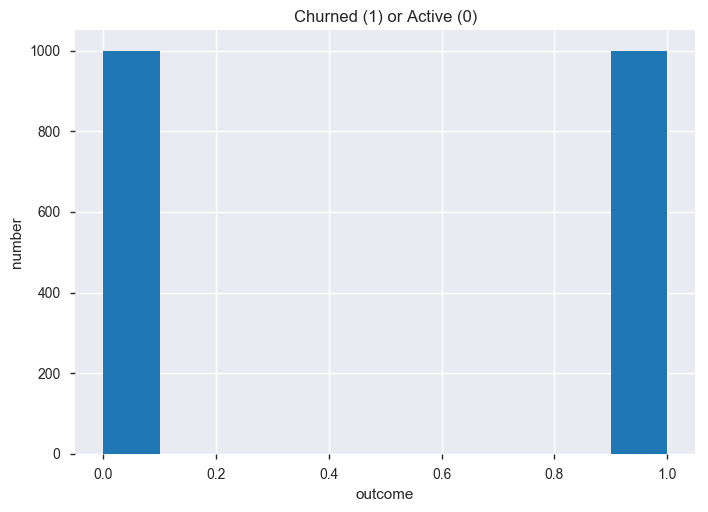

In [6]:
data['Class'].hist()
plt.title('Churned (1) or Active (0)')
plt.xlabel('outcome')
plt.ylabel('number')

In [7]:
pandas_profiling.ProfileReport(data)

Number of variables,14
Number of observations,2000
Total Missing (%),1.6%
Total size in memory,218.8 KiB
Average record size in memory,112.0 B
Numeric,9
Categorical,4
Boolean,1
Date,0
Text (Unique),0
Rejected,0


from : http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/

*Pearson product moment correlation*

The Pearson correlation evaluates the linear relationship between two continuous variables. A relationship is linear when a change in one variable is associated with a proportional change in the other variable.

For example, you might use a Pearson correlation to evaluate whether increases in temperature at your production facility are associated with decreasing thickness of your chocolate coating.

*Spearman rank-order correlation*

The Spearman correlation evaluates the monotonic relationship between two continuous or ordinal variables. In a monotonic relationship, the variables tend to change together, but not necessarily at a constant rate. The Spearman correlation coefficient is based on the ranked values for each variable rather than the raw data.

Spearman correlation is often used to evaluate relationships involving ordinal variables. For example, you might use a Spearman correlation to evaluate whether the order in which employees complete a test exercise is related to the number of months they have been employed.

It is always a good idea to examine the relationship between variables with a scatterplot. Correlation coefficients only measure linear (Pearson) or monotonic (Spearman) relationships. Other relationships are possible.

In [117]:
correlation = abs(df.corr())
mask = abs(correlation) > 0.6
cmap = 'Reds'#cmap=sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

correlation.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,network_age,Aggregate_Total_Rev,Aggregate_SMS_Rev,Aggregate_Data_Rev,Aggregate_Data_Vol,Aggregate_Calls,Aggregate_ONNET_REV,Aggregate_OFFNET_REV,Aggregate_complaint_count,Class
network_age,1,0.17,0.054,0.03,0.014,0.22,0.017,0.099,0.06,0.18
Aggregate_Total_Rev,0.17,1,0.34,0.62,0.13,0.54,0.43,0.72,0.088,0.21
Aggregate_SMS_Rev,0.054,0.34,1,0.31,0.053,0.047,0.17,0.26,0.00053,0.051
Aggregate_Data_Rev,0.03,0.62,0.31,1,0.093,0.057,0.14,0.28,0.062,0.0015
Aggregate_Data_Vol,0.014,0.13,0.053,0.093,1,0.013,0.046,0.0069,0.025,0.16
Aggregate_Calls,0.22,0.54,0.047,0.057,0.013,1,0.26,0.44,0.086,0.28
Aggregate_ONNET_REV,0.017,0.43,0.17,0.14,0.046,0.26,1,0.45,0.034,0.099
Aggregate_OFFNET_REV,0.099,0.72,0.26,0.28,0.0069,0.44,0.45,1,0.045,0.013
Aggregate_complaint_count,0.06,0.088,0.00053,0.062,0.025,0.086,0.034,0.045,1,0.074
Class,0.18,0.21,0.051,0.0015,0.16,0.28,0.099,0.013,0.074,1


In [ ]:
# Revenue data is correlated with other revenue data. Not super surprising. Probably isn't too big of a deal though, 
# correlation isn't too bad
# None of the numerical variables is that highly correlated with whether the account churns or not.

In [28]:
def plot_stack_chart(df, col1, col2 ):
    df = df.groupby([col1, col2])[col2].count().fillna(0).groupby(level=[0]).apply(lambda x: x / x.sum()).unstack(col2)
    df.plot(kind='bar', stacked=True, title = col1 + ' vs ' + col2)
 

In [41]:
def plot_stack_chart_not_normalized(df, col1, col2 ):
    df = df.groupby([col1, col2])[col2].count().fillna(0).groupby(level=[0]).apply(lambda x: x ).unstack(col2)
    df.plot(kind='bar', stacked=True, title = col1 + ' vs ' + col2)

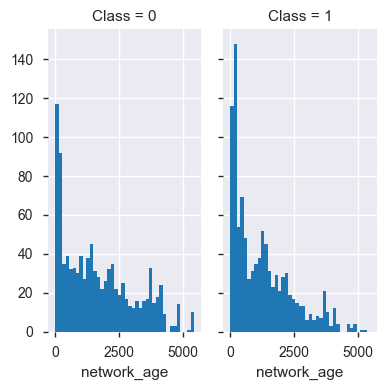

In [16]:
import seaborn as sns
df = data.copy()
g = sns.FacetGrid(df, col="Class", size=4, aspect=.5)
g = g.map(plt.hist, "network_age", bins=40)

In [10]:
# The scatter plot isn't too helpful for visualizing, so let's see if the mean and median are any different
df.groupby('Class').mean()

,network_age
Class,
0,1698.571
1,1240.538


In [11]:
df.groupby('Class').median()

,network_age
Class,
0,1423.5
1,943.0


In [12]:
# For both the mean and median, the newer accounts are more likely to churn. Let's look at the standard deviations
df.groupby('Class').std()

,network_age
Class,
0,1381.023411
1,1140.569014


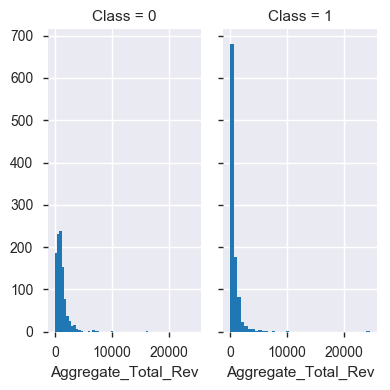

In [18]:
g = sns.FacetGrid(df, col="Class", size=4, aspect=.5)
g = g.map(plt.hist, "Aggregate_Total_Rev", bins=40)

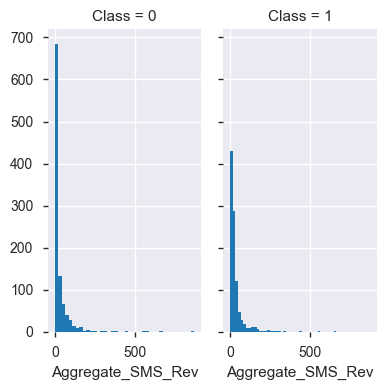

In [20]:
g = sns.FacetGrid(df, col="Class", size=4, aspect=.5)
g = g.map(plt.hist, "Aggregate_SMS_Rev", bins=40)

In [17]:
df.columns.values

array(['network_age', 'Aggregate_Total_Rev', 'Aggregate_SMS_Rev',
       'Aggregate_Data_Rev', 'Aggregate_Data_Vol', 'Aggregate_Calls',
       'Aggregate_ONNET_REV', 'Aggregate_OFFNET_REV',
       'Aggregate_complaint_count', 'aug_user_type', 'sep_user_type',
       'aug_fav_a', 'sep_fav_a', 'Class'], dtype=object)

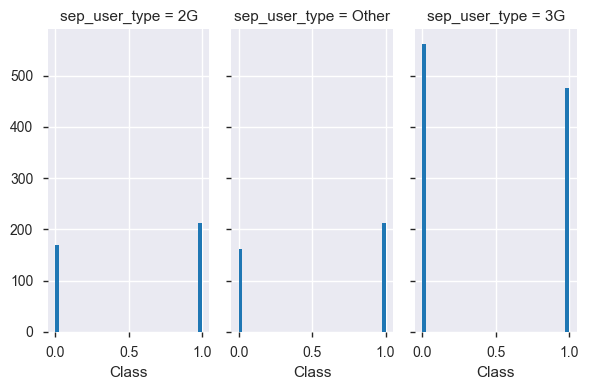

In [23]:
g = sns.FacetGrid(df, col="sep_user_type", size=4, aspect=.5)
g = g.map(plt.hist, "Class", bins=40)

# looks like other and 2G have higher churn rates than september user type

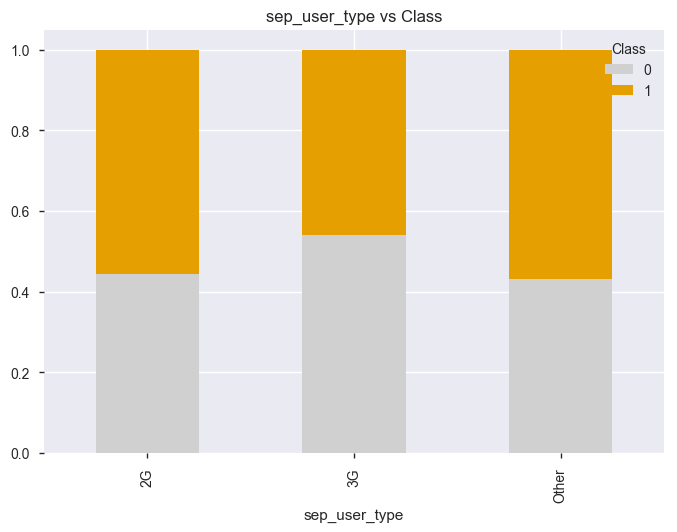

In [26]:
colors = ["#d0d0d0", "#E69F00"]
plot_stack_chart(df, 'sep_user_type', 'Class' )

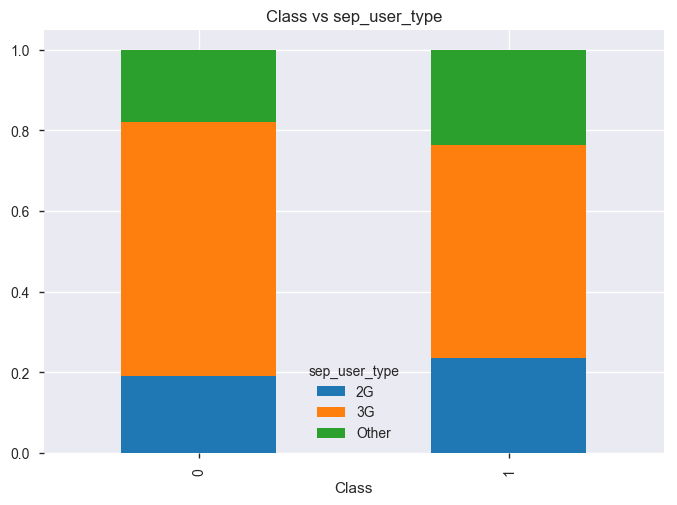

In [29]:
plot_stack_chart(df, 'Class', 'sep_user_type' )

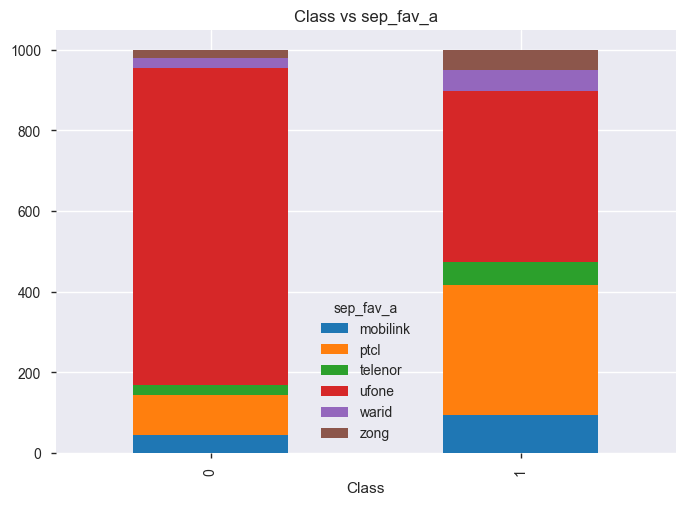

In [47]:
plot_stack_chart_not_normalized(df, 'Class', 'sep_fav_a' )

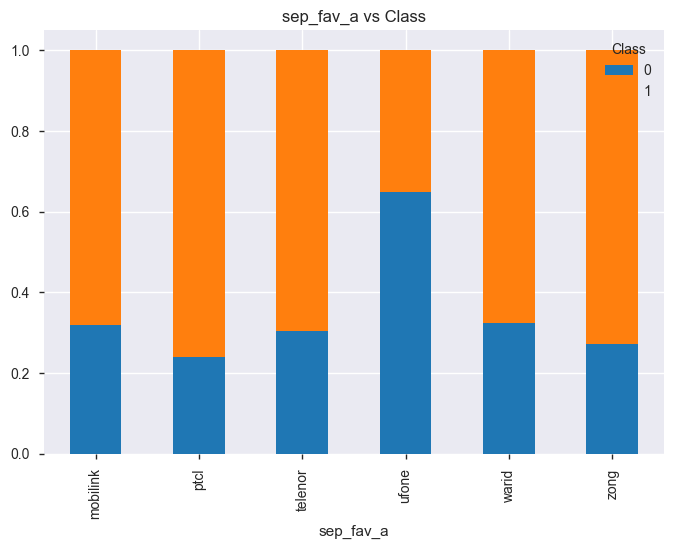

In [31]:
plot_stack_chart(df, 'sep_fav_a', 'Class' )

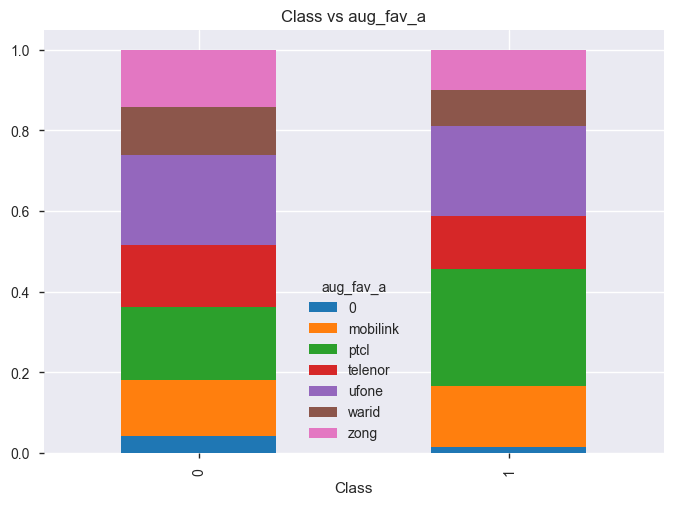

In [32]:
plot_stack_chart(df, 'Class', 'aug_fav_a' )

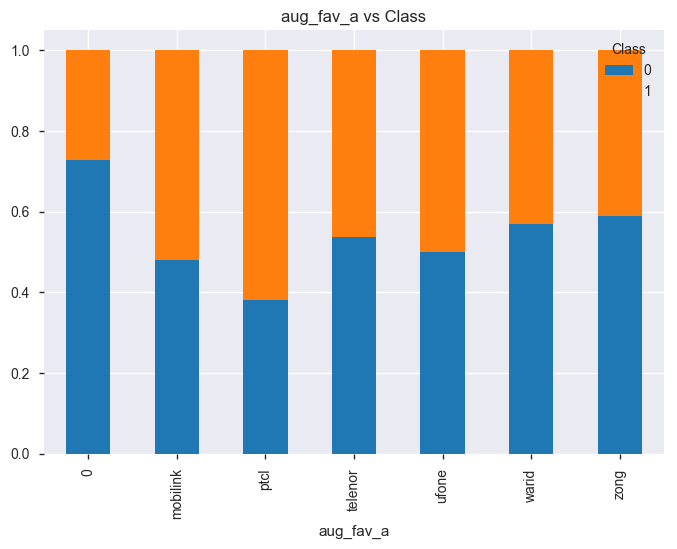

In [43]:
plot_stack_chart(df, 'aug_fav_a','Class' )

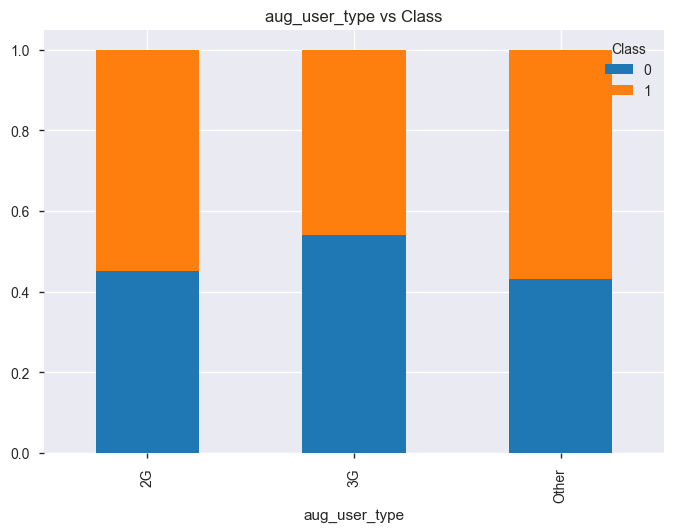

In [34]:
# aug_user_type
plot_stack_chart(df, 'aug_user_type','Class' )

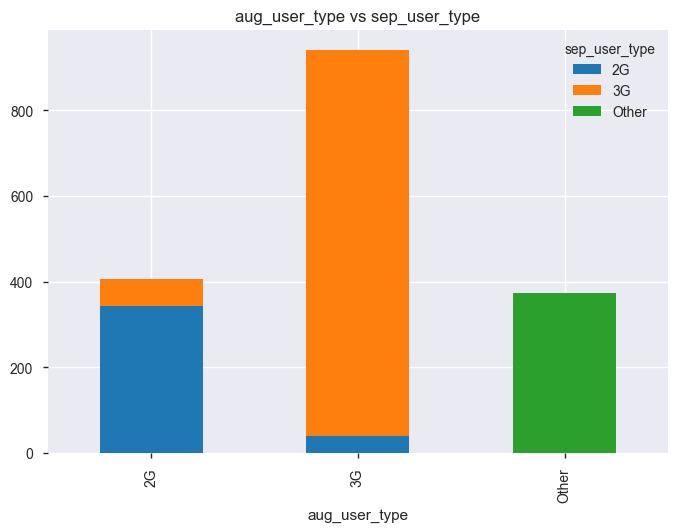

In [44]:
# user type seems to be more stable. I'm not sure what that favorite thing is
plot_stack_chart_not_normalized(df, 'aug_user_type','sep_user_type' )

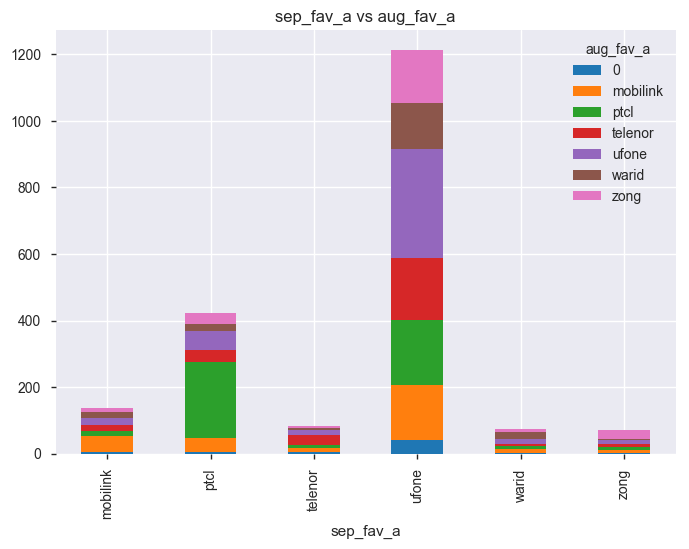

In [45]:
plot_stack_chart_not_normalized(df, 'sep_fav_a','aug_fav_a' )

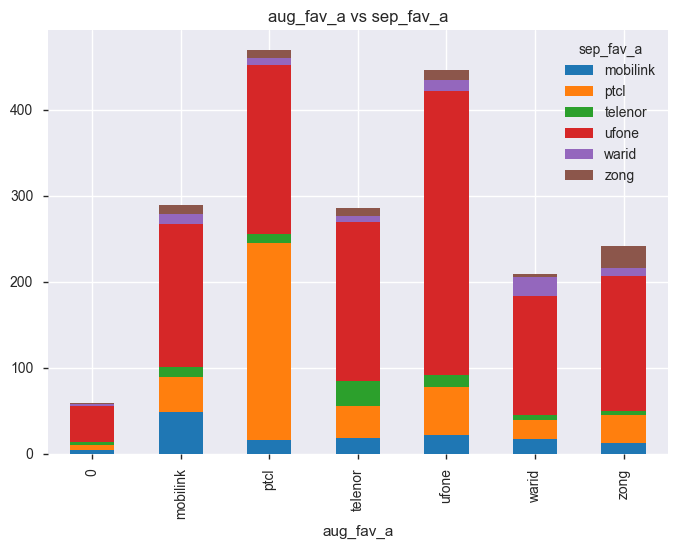

In [49]:
plot_stack_chart_not_normalized(df,'aug_fav_a', 'sep_fav_a' )

In [ ]:
# ufone got way more popular in september. big jump between august and september. What does that mean anyway?

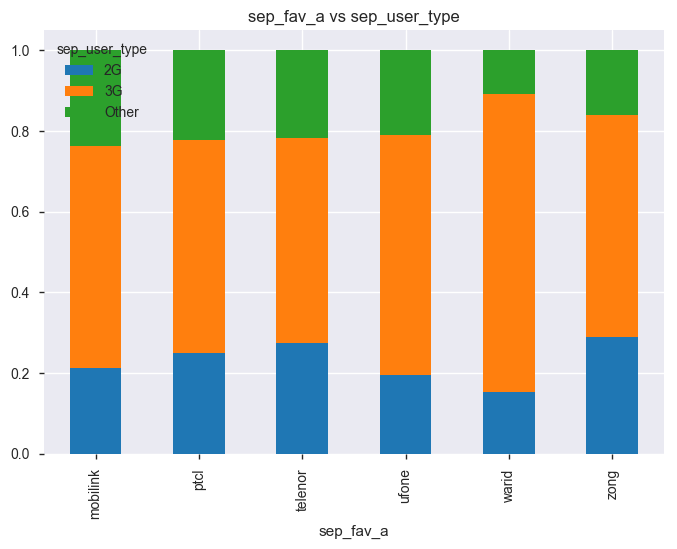

In [52]:
# lots of movement between the september and august favorites. Does that mean that people 
plot_stack_chart(df,'sep_fav_a', 'sep_user_type' )

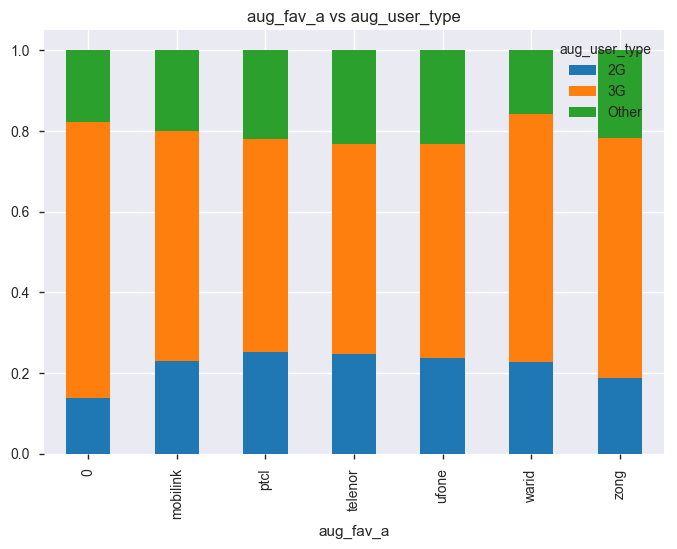

In [53]:
plot_stack_chart(df,'aug_fav_a', 'aug_user_type' )

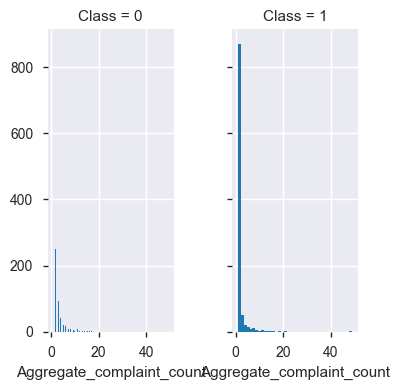

In [54]:
g = sns.FacetGrid(df, col="Class", size=4, aspect=.5)
g = g.map(plt.hist, "Aggregate_complaint_count", bins=40)

In [63]:
df.groupby('Class').mean()['Aggregate_complaint_count']
# Looks like people who complain less may be more likely to churn

Class
0    2.091
1    1.758
Name: Aggregate_complaint_count, dtype: float64

In [66]:
df.groupby('Class').describe()['Aggregate_complaint_count']
# In either case, the minimum complaint count is 1. Nobody complains 0. Weird.
# Much larger instance of just one. (seems like that from histogram anyway)

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,1000.0,2.091,2.036877,1.0,1.0,1.0,2.0,17.0
1,1000.0,1.758,2.463230,1.0,1.0,1.0,2.0,49.0


In [89]:
churned = df[df.Class==1]
active = df[df.Class==0]

classes = [churned, active]

In [90]:
churned.describe()

,network_age,Aggregate_Total_Rev,Aggregate_SMS_Rev,Aggregate_Data_Rev,Aggregate_Data_Vol,Aggregate_Calls,Aggregate_ONNET_REV,Aggregate_OFFNET_REV,Aggregate_complaint_count,Class
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.00000,1000.0
mean,1240.538000,659.810487,34.051940,59.179380,1.375047e+06,138.877000,5772.684000,16003.760000,1.75800,1.0
std,1140.569014,1170.603753,55.350899,321.354525,4.544617e+06,231.006658,16602.187673,35408.604654,2.46323,0.0
min,-8.000000,7.770000,0.000000,0.000000,5.860000e-02,1.000000,0.000000,0.000000,1.00000,1.0
25%,240.000000,128.600000,7.170000,1.250000,7.001431e+02,14.000000,24.000000,1244.500000,1.00000,1.0
50%,943.000000,362.394000,19.710000,11.250000,5.347908e+04,48.000000,998.000000,4134.500000,1.00000,1.0
75%,1880.250000,813.937500,36.722500,41.250000,8.063143e+05,159.250000,5011.500000,14588.000000,2.00000,1.0
max,5355.000000,24438.830000,664.920000,8295.000000,6.405457e+07,2596.000000,381174.000000,431440.000000,49.00000,1.0


In [91]:
active.describe()

,network_age,Aggregate_Total_Rev,Aggregate_SMS_Rev,Aggregate_Data_Rev,Aggregate_Data_Vol,Aggregate_Calls,Aggregate_ONNET_REV,Aggregate_OFFNET_REV,Aggregate_complaint_count,Class
count,1000.000000,1000.000000,1000.000000,1000.00000,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000,1000.0
mean,1698.571000,1150.229725,28.165270,58.43278,4.172875e+06,342.94400,9049.885000,16911.395000,2.091000,0.0
std,1381.023411,1077.803487,60.241685,138.79653,1.148846e+07,446.78333,16229.426769,33190.657524,2.036877,0.0
min,6.000000,4.910000,0.000000,0.00000,1.016000e-01,1.00000,0.000000,0.000000,1.000000,0.0
25%,419.750000,498.774300,1.750000,1.25000,2.729161e+04,54.00000,311.000000,1844.750000,1.000000,0.0
50%,1423.500000,948.156000,9.600000,17.50000,4.484702e+05,181.50000,2994.000000,6162.000000,1.000000,0.0
75%,2643.750000,1456.219500,28.912500,62.50000,2.622822e+06,495.50000,10758.250000,16900.750000,2.000000,0.0
max,5451.000000,16387.316000,873.980000,2327.50000,1.550312e+08,5727.00000,158880.000000,379475.000000,17.000000,0.0


In [106]:
col = 'network_age'

numerical_cols = ['network_age',
                 'Aggregate_Total_Rev',
                 'Aggregate_SMS_Rev', 
                 'Aggregate_Data_Rev',
                  'Aggregate_Data_Vol', 
                 'Aggregate_Calls', 
                 'Aggregate_ONNET_REV',
                 'Aggregate_OFFNET_REV',
                 'Aggregate_complaint_count']

for col in numerical_cols:
    plot_data = []
    for dat in classes:
        bplot = dat[col]
        plot_data.append(bplot)

    plot_data.append(df[col])

    plt.boxplot(plot_data, 0, '')
    labels = [item.get_text() for item in plt.gca().get_xticklabels()]
    labels[-1] = 'All'
    labels[0] = 'Churned'
    labels[1] = 'Active'
    plt.gca().set_xticklabels(labels)
    plt.title(col)

    plt.savefig('./plots/'+col + '.pdf')
    plt.close()

## check for collinearity